In [83]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
from qiskit.circuit.library import TwoLocal


import numpy as np
import pandas as pd
from qiskit_algorithms.utils import algorithm_globals
import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt

import random

from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, Binary, maximize
from scipy.optimize import minimize
from itertools import combinations

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import *
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.primitives import Estimator
from qiskit.primitives import Sampler,  BackendSampler, BackendSamplerV2

from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Estimator
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.circuit.library import QAOAAnsatz

from qiskit.circuit.library import EfficientSU2

from qiskit_algorithms.optimizers import SPSA

from qiskit_algorithms import SamplingVQE




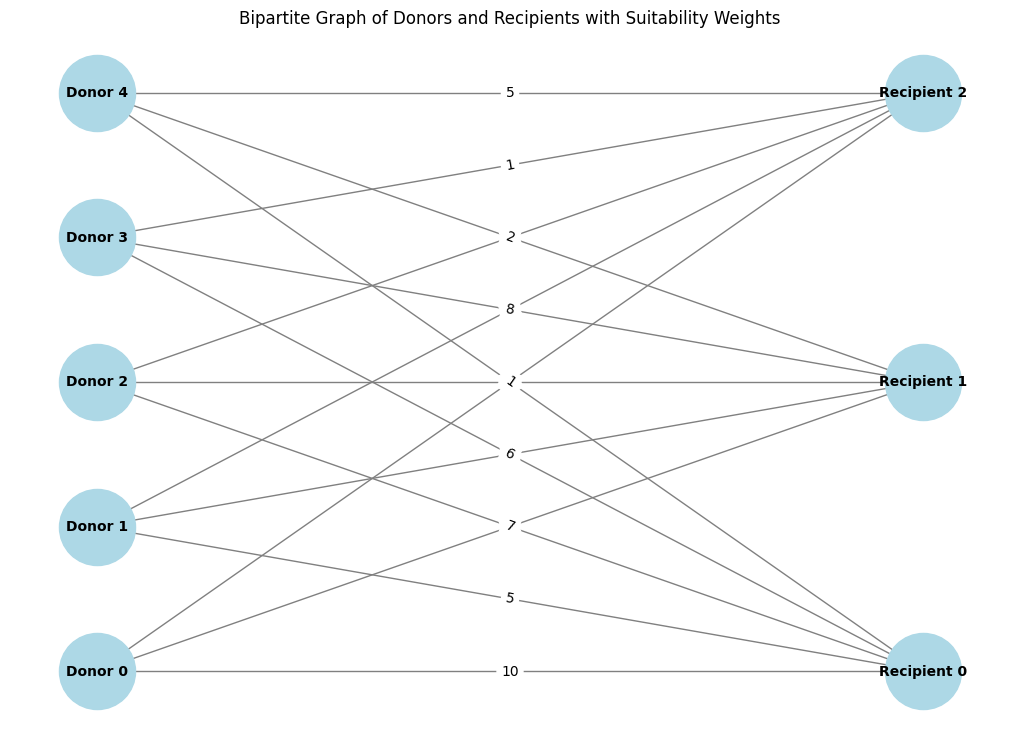

In [79]:
import matplotlib.pyplot as plt
import networkx as nx
from qiskit_optimization import QuadraticProgram

# Define the problem
n_donors = 5  # Number of donors
n_recipients = 3  # Number of recipients
weights = [
    [10, 2, 1],  # Donor 0
    [5, 9, 4],   # Donor 1
    [7, 3, 2],  # Donor 2
    [6, 8, 1],  # Donor 3
    [1, 2, 5]    # Donor 4
]  # Example weights

# Initialize QUBO
qubo = QuadraticProgram()

# Add binary variables for each pair (donor, recipient)
for i in range(n_donors):
    for j in range(n_recipients):
        qubo.binary_var(name=f"x_{i}_{j}")

# Set the objective function (maximize total suitability)
objective_terms = []
for i in range(n_donors):
    for j in range(n_recipients):
        objective_terms.append(weights[i][j])

# The objective should be a weighted sum of all pairwise terms
qubo.maximize(linear={f"x_{i}_{j}": weights[i][j] for i in range(n_donors) for j in range(n_recipients)})

# Create a bipartite graph for visualization
G = nx.Graph()

# Add nodes for donors and recipients
donor_nodes = [f"Donor {i}" for i in range(n_donors)]
recipient_nodes = [f"Recipient {j}" for j in range(n_recipients)]
G.add_nodes_from(donor_nodes, bipartite=0)
G.add_nodes_from(recipient_nodes, bipartite=1)

# Add weighted edges between donors and recipients
for i in range(n_donors):
    for j in range(n_recipients):
        G.add_edge(donor_nodes[i], recipient_nodes[j], weight=weights[i][j])

# Draw the bipartite graph
pos = nx.bipartite_layout(G, nodes=donor_nodes)
plt.figure(figsize=(10, 7))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Bipartite Graph of Donors and Recipients with Suitability Weights")
plt.show()


In [80]:
# Print all binary variables
for i in range(n_donors):
    for j in range(n_recipients):
        print(f"Variable x_{i}_{j}: {qubo.get_variable(f'x_{i}_{j}')}")

# Print and verify constraints
for i in range(n_donors):
    print(f"Donor {i} constraint:", {f"x_{i}_{j}": 1 for j in range(n_recipients)})

for j in range(n_recipients):
    print(f"Recipient {j} constraint:", {f"x_{i}_{j}": 1 for i in range(n_donors)})


Variable x_0_0: x_0_0 (binary)
Variable x_0_1: x_0_1 (binary)
Variable x_0_2: x_0_2 (binary)
Variable x_1_0: x_1_0 (binary)
Variable x_1_1: x_1_1 (binary)
Variable x_1_2: x_1_2 (binary)
Variable x_2_0: x_2_0 (binary)
Variable x_2_1: x_2_1 (binary)
Variable x_2_2: x_2_2 (binary)
Variable x_3_0: x_3_0 (binary)
Variable x_3_1: x_3_1 (binary)
Variable x_3_2: x_3_2 (binary)
Variable x_4_0: x_4_0 (binary)
Variable x_4_1: x_4_1 (binary)
Variable x_4_2: x_4_2 (binary)
Donor 0 constraint: {'x_0_0': 1, 'x_0_1': 1, 'x_0_2': 1}
Donor 1 constraint: {'x_1_0': 1, 'x_1_1': 1, 'x_1_2': 1}
Donor 2 constraint: {'x_2_0': 1, 'x_2_1': 1, 'x_2_2': 1}
Donor 3 constraint: {'x_3_0': 1, 'x_3_1': 1, 'x_3_2': 1}
Donor 4 constraint: {'x_4_0': 1, 'x_4_1': 1, 'x_4_2': 1}
Recipient 0 constraint: {'x_0_0': 1, 'x_1_0': 1, 'x_2_0': 1, 'x_3_0': 1, 'x_4_0': 1}
Recipient 1 constraint: {'x_0_1': 1, 'x_1_1': 1, 'x_2_1': 1, 'x_3_1': 1, 'x_4_1': 1}
Recipient 2 constraint: {'x_0_2': 1, 'x_1_2': 1, 'x_2_2': 1, 'x_3_2': 1, 'x_4_2'

In [85]:
backend = AerSimulator(max_parallel_shots=1)

algorithm_globals.random_seed = 10598

# Set up the optimizer
optimizer = COBYLA()
opt = SPSA(maxiter=50)
sampler = Sampler()
# Set up the QAOA with the Estimator primitive
estimator = Estimator()
print("qaoa starting")
qaoa_mes = QAOA(sampler=sampler, optimizer=optimizer, reps=2) 
print("qaoa done")


qubo_to_qubo = QuadraticProgramToQubo()

qubo_model = qubo_to_qubo.convert(qubo)

ising = qubo_model.to_ising()

print(qubo_model.export_as_lp_string())

qaoa starting
qaoa done
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 10 x_0_0 - 2 x_0_1 - x_0_2 - 5 x_1_0 - 9 x_1_1 - 4 x_1_2 - 7 x_2_0
      - 3 x_2_1 - 2 x_2_2 - 6 x_3_0 - 8 x_3_1 - x_3_2 - x_4_0 - 2 x_4_1
      - 5 x_4_2
Subject To

Bounds
 0 <= x_0_0 <= 1
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_1 <= 1
 0 <= x_1_2 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_1 <= 1
 0 <= x_2_2 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_1 <= 1
 0 <= x_3_2 <= 1
 0 <= x_4_0 <= 1
 0 <= x_4_1 <= 1
 0 <= x_4_2 <= 1

Binaries
 x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2 x_3_0 x_3_1 x_3_2 x_4_0
 x_4_1 x_4_2
End



In [86]:
# Use Minimum Eigen Optimizer to solve the QUBO
qaoa = MinimumEigenOptimizer(qaoa_mes)
print("Here!")
result = qaoa.solve(qubo)

# Extract results
print("Solution:", result)
print("Objective value:", result.fval)
#result = qaoa.compute_minimum_eigenvalue(operator=ising[0])


#print("Optimal value:", result.eigenvalue)
#print("Optimal solution:", result.eigenstate)

Here!


TypeError: SamplerV2.run() takes 2 positional arguments but 3 were given

In [59]:
print(result.x)
# Print matched pairs
for i in range(n_donors):
    for j in range(n_recipients):
        if result.x[i * n_recipients + j] > 0.5: #Bu kısmı değitirmem gerekebilir.
            print(f"Donor {i} matched with Recipient {j}")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [60]:
print("variable order:", [var.name for var in result.variables])
for s in result.samples:
    print(s)

variable order: ['x_0_0', 'x_0_1', 'x_0_2', 'x_1_0', 'x_1_1', 'x_1_2', 'x_2_0', 'x_2_1', 'x_2_2', 'x_3_0', 'x_3_1', 'x_3_2', 'x_4_0', 'x_4_1', 'x_4_2']
SolutionSample(x=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), fval=0.0, probability=6.5855093657e-06, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), fval=66.0, probability=0.0001428301331799, status=<OptimizationResultStatus.INFEASIBLE: 2>)
SolutionSample(x=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]), fval=65.0, probability=1.8888557226e-05, status=<OptimizationResultStatus.INFEASIBLE: 2>)
SolutionSample(x=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.]), fval=65.0, probability=2.43583456932e-05, status=<OptimizationResultStatus.INFEASIBLE: 2>)
SolutionSample(x=array([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), fval=65.0, probability=2.43583456932e-05, status=<Optimizat

In [49]:
optimal_solution = result.eigenstate
most_probable_solution = max(optimal_solution, key=optimal_solution.get)
probability = optimal_solution[most_probable_solution]

# Convert the integer to a binary string
binary_string = format(most_probable_solution, '0' + str(n_donors * n_recipients) + 'b')

# Decode the binary string
matches = []
index = 0
for i in range(n_donors):
    for j in range(n_recipients):
        if binary_string[index] == '1':
            matches.append((i, j))
        index += 1

# Print the matches
print(f"Optimal value: {result.eigenvalue}")
print(f"Optimal solution (binary string): {binary_string}")
print(f"Donor-Recipient matches:")
for donor, recipient in matches:
    print(f"Donor {donor} is matched with Recipient {recipient}")

AttributeError: 'MinimumEigenOptimizationResult' object has no attribute 'eigenstate'

In [64]:
print(binary_vector)

{61403: 0.0009765625, 9251: 0.0009765625, 15211: 0.0009765625, 3104: 0.0009765625, 57382: 0.0009765625, 63351: 0.0009765625, 56378: 0.0009765625, 57402: 0.0009765625, 31758: 0.0009765625, 15769: 0.0009765625, 65190: 0.0009765625, 23401: 0.0009765625, 46281: 0.0009765625, 15047: 0.0009765625, 63957: 0.0009765625, 41640: 0.0009765625, 52292: 0.0009765625, 37821: 0.0009765625, 25687: 0.0009765625, 51588: 0.0009765625, 34877: 0.0009765625, 37132: 0.0009765625, 15065: 0.0009765625, 10455: 0.0009765625, 27575: 0.0009765625, 54754: 0.0009765625, 54049: 0.0009765625, 12450: 0.0009765625, 46071: 0.0009765625, 27861: 0.0009765625, 16371: 0.0009765625, 60026: 0.0009765625, 40907: 0.0009765625, 8603: 0.0009765625, 51942: 0.0009765625, 58374: 0.001953125, 55384: 0.0009765625, 24590: 0.0009765625, 29241: 0.0009765625, 28906: 0.0009765625, 41673: 0.0009765625, 7249: 0.0009765625, 44280: 0.0009765625, 44829: 0.0009765625, 57017: 0.0009765625, 38446: 0.0009765625, 23520: 0.0009765625, 26074: 0.00097656

In [50]:
initial_state = None
mixer = None

# Create the QAOA ansatz circuit
qaoa_ansatz = QAOAAnsatz(operator=operator, reps=reps, initial_state=initial_state, mixer_operator=mixer)

# Draw the QAOA circuit
circuit_drawer(qaoa_ansatz.decompose(), output='mpl')

NameError: name 'operator' is not defined